# Receiver side implementation: OFDM in 5G Networks

Orthogonal Frequency Division Multiplexing (**OFDM**) is a modulation technique used in wireless communication systems to transmit data over radio waves. Following are a few features of OFDM technology: 


1. **Orthogonal Frequencies**: OFDM divides the available spectrum into multiple narrowband subcarriers that are orthogonal to each other. Orthogonality means that these subcarriers do not interfere with each other, even though they occupy the same frequency range.
2. **Frequency Division Multiplexing (FDM)**: Each subcarrier is modulated with data, and multiple subcarriers are transmitted simultaneously. This allows for higher data rates compared to traditional single-carrier modulation schemes.
3. **Guard Intervals**: OFDM incorporates guard intervals between symbols to mitigate the effects of multipath interference. These guard intervals help in maintaining orthogonality between subcarriers even in the presence of channel distortions.
4. **Efficiency**: OFDM is highly efficient in utilizing available spectrum, allowing for high data rates and robustness against frequency-selective fading and interference.
5. **MIMO and Beamforming**: OFDM is often used in conjunction with Multiple Input Multiple Output (MIMO) and beamforming techniques in 5G networks to further enhance spectral efficiency and coverage.

OFDM is widely used in various wireless communication standards such as Wi-Fi, LTE (Long-Term Evolution),
WiMAX, and 5G due to its ability to provide high-speed data transmission, robustness to interference,
and efficient spectrum utilization.

## 4.2 Import Libraries
### 4.2 Import Python and SDR Libraries

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))


# %matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import numpy as np
import adi

import matplotlib.patches as patches
import matplotlib.animation as animation

### 4.2 Import 5G Toolkit Libraries 

In [2]:

import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


## 4.2 Emulation Parameters

In [3]:

# System Parameters
center_frequency    = 1e9     # Carrier frequency for signal transmission

# OFDM Parameters
Bandwidth           = 5*10**6 # bandwidth
fftSize             = 1024    # FFT-size for OFDM
subcarrier_spacing  = 15000   # Subcarrier spacing
numOFDMSymbols      = 14      # Number of OFDM symbols considered for emulation | 1 slot
sample_rate         = fftSize*subcarrier_spacing # sample rate required by OFDM and DAC/ADC of SDR

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(4*fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


In [4]:
nSymbolFrame= 140*int(subcarrier_spacing/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftsize = fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff          # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
fftsize     = tfParams.fftsize       # FFT-size for OFDM
lengthCP    = tfParams.lengthCP      # CP length


## 4.2 SDR-Setup Configurations

In [5]:

# SDR setup
sdr             = adi.Pluto("ip:192.168.3.1")       # Create object of SDR setup object and configure the IP of SDR connect to the system
sdr.sample_rate = int(sample_rate)                  # Sets the sample rate for the ADC/DAC of the SDR.

# Config Rx
sdr.rx_lo                   = int(center_frequency) # Sets the receiver local oscillator frequency. 
# For Pluto SDR, rx_lo can take a value between 325 MHz to 3.8 GHz.
sdr.rx_rf_bandwidth         = int(60*10**6)         # Set the bandwidth (in Hz) of the reception filter
# For Pluto SDR, tx_rf_bandwidth should be between 200 kHz and 56 MHz.
sdr.rx_buffer_size          = int(buffer_size)      # Number of samples to read and load into SDR buffer.
# The upper limit on the size of this buffer is defined by the DRAM size.

sdr.gain_control_mode_chan0 = 'manual'              # Defines the mode of receiver AGC.
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

sdr.rx_hardwaregain_chan0   = 40.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC
# Sets the amplification gain (dB) provided by the low noise amplifier (LNA). 
# Relevant only when `gain_control_mode_chan0` is "manual".


## 4.2 Reception
## 4.2 Receive Samples from SDR

In [6]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # Stop transmitting
# sdr.tx_destroy_buffer()


## 4.2 Time Synchronization: Detection of PSS

**(rasterOffset, PSS-ID) (362, 0)
**(rasterOffset, PSS-ID) (362, 1)
**(rasterOffset, PSS-ID) (362, 2)


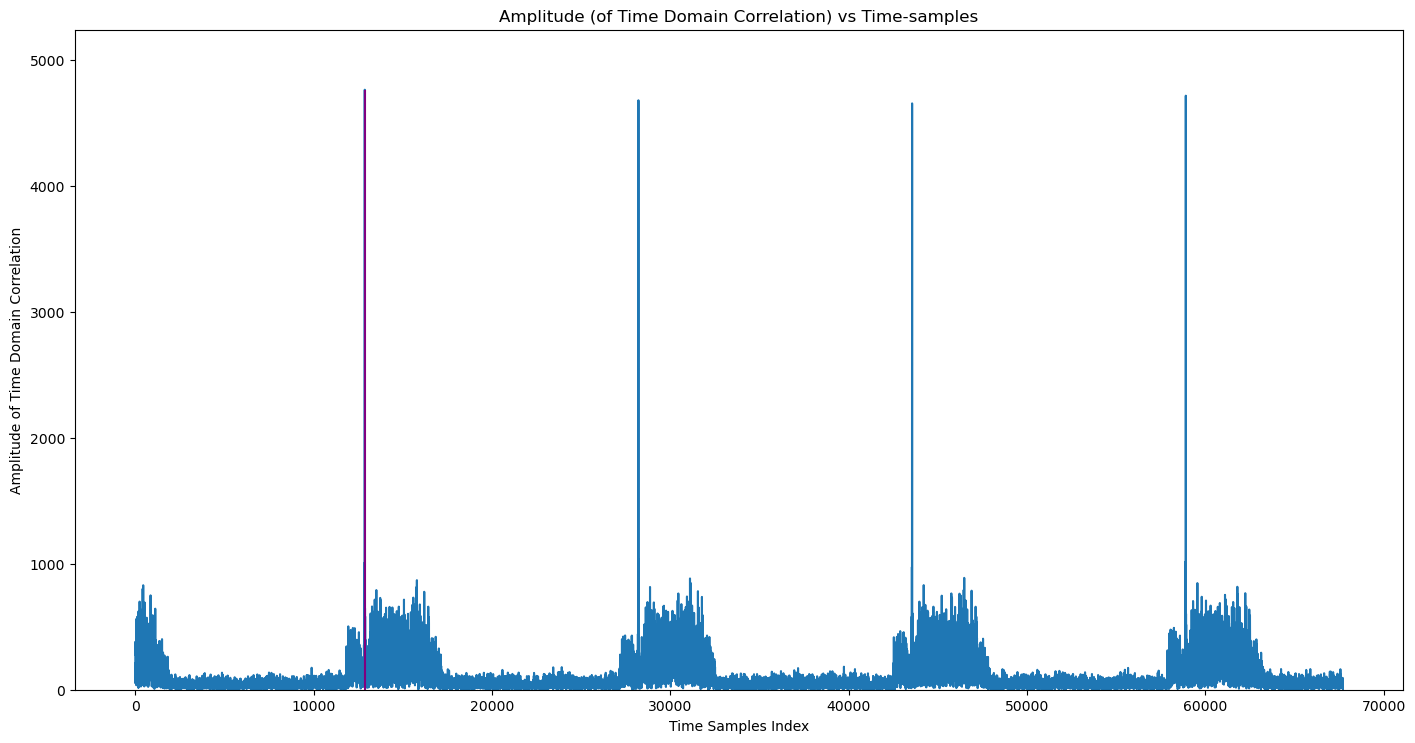

In [7]:
## PSS Detection: Based on time domain PSS Correlation

pssDetection   = PSSDetection("largestPeak")
# ssboffset      = int((fftSize-Neff)/2+ssbRGobject.startingSubcarrierIndices)
ssboffset      = int((fftSize-Neff)/2)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1], 
                                                                  nID2=None, freqOffset = ssboffset)

# pssPeakIndices: indicates the time/sample indices where time correlation has spikes
    # 1. Spikes are computed based on the Input parameters related to peak detector
    
# pssCorrelation: Returns the correlation plot for the selected cell-ID 2.
# rN_ID2: Detected Cell ID2 by the algorithm
# freqOffset: frequency offset where SSB/PSS was detected.


## PSS Detection Plot
#################################################################
scaleFig = 1.75
fig, ax  = plt.subplots(figsize=(30/scaleFig, 15/scaleFig))

ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________

## 4.2 OFDM Demodulation: Receiver 
-- The transmitted SSB is receovered at receiver.

![](OFDMRx.png)

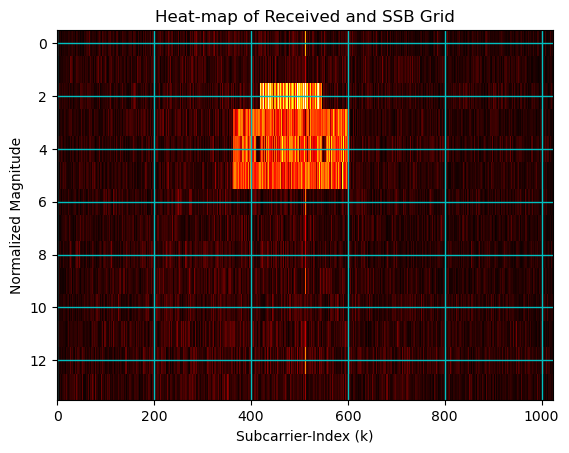

In [8]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
pssStartIndex   = pssPeakIndices

initial         = pssStartIndex - 2*(fftSize+lengthCP[1])
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
rxGrid          = ofdmDemodulator(np.complex64(rx_samples.reshape(1,-1))[...,initial:(initial+14*(fftSize+lengthCP[1]))])

# Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(rxGrid[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received and SSB Grid")
plt.show()

## 4.2 Quasi-realtime reception of OFDM Grid


``Note``: The following snippet of code only works with interactive maplotlib.

1. ![caution2-3](caution.jpg) **Please ensure that you have intractive matplotlib installed on your system.**
2. **uncomment the ``%matplotlib widget`` in first code block for the following section of code to work**

In [9]:
# function that draws each frame of the animation
def animate(i):
    # Receive samples
    rx_samples = sdr.rx()
    
    pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1], 
                                                                  nID2=None, freqOffset = ssboffset)
    
    if(pssPeakIndices < 3*(fftSize + lengthCP[1])):
        pssPeakIndices = pssPeakIndices + 14*(fftSize + lengthCP[1])
    elif(pssPeakIndices > rx_samples.size - 13*(fftSize + lengthCP[1])):
        pssPeakIndices = pssPeakIndices - 14*(fftSize + lengthCP[1])
    
    ## OFDM Demodulator Object
    ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
    pssStartIndex   = pssPeakIndices

    initial         = pssStartIndex - 2*(fftSize+lengthCP[1])
    ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
    rxGrid          = ofdmDemodulator(np.complex64(rx_samples.reshape(1,-1))[...,initial:(initial+14*(fftSize+lengthCP[1]))])
    
    ax.clear()
    ax.grid(color='c', linestyle='-', linewidth=1)
    ax.set_xlabel("Subcarrier-Index (k)")
    ax.set_ylabel("Normalized Magnitude")
    ax.set_title("Heat-map of Received and SSB Grid")
    ax.imshow(np.abs(rxGrid[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
    ax.set_ylim([13.5,-0.5])
    ax.set_xlim([0,fftSize])


# Plot SSB
fig, ax = plt.subplots()

scale = 100
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim = animation.FuncAnimation(fig, animate, frames=1000, interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
plt.show()

anim.save("OFDM_UE2.gif", fps = 1000)

# writervideo = animation.FFMpegWriter(fps=60) 
# anim.save('Overall.mp4', writer=writervideo)

![Overall-4.2](OFDM_UE2.gif)